In [1]:
# Student: Thang Bui Doan

# Question 3.1:

$\frac{\partial f}{\partial w_0} = \frac{1}{n} \sum{\frac{-y_iexp(y_ix_{i}^{T}w+w_0)}{1+exp(y_ix_{i}^{T}w+w_0)}}$

$\frac{\partial f}{\partial w} = \frac{1}{n} \sum{\frac{-y_ix_iexp(y_ix_{i}^{T}w+w_0)}{1+exp(y_ix_{i}^{T}w+w_0)}} + \rho w$

$\frac{\partial ^2f}{\partial w^2} = \frac{1}{n} \sum{\frac{y_i^2x_ix_i^Texp(y_ix_{i}^{T}w+w_0)}{(1+exp(y_ix_{i}^{T}w+w_0))^2}} + \rho*I$

$\frac{\partial ^2f}{\partial w_0 \partial w} = \frac{1}{n} \sum{\frac{y_i^2x_iexp(y_ix_{i}^{T}w+w_0)}{(1+exp(y_ix_{i}^{T}w+w_0))^2}}$

$\frac{\partial ^2f}{\partial w_0^2} = \frac{1}{n} \sum{\frac{y_i^2exp(y_ix_{i}^{T}w+w_0)}{(1+exp(y_ix_{i}^{T}w+w_0))^2}}$

Jacobian matrix: $\begin{pmatrix}
\frac{\partial f}{\partial w_0} \\
\frac{\partial f}{\partial w}
\end{pmatrix}$

Hessian matrix: $\begin{pmatrix}
\frac{\partial^2 f}{\partial w_0^2} & [\frac{\partial^2f}{\partial w_0 \partial w}]^T \\
\frac{\partial^2f}{\partial w_0 \partial w} & \frac{\partial^2 f}{\partial w^2}
\end{pmatrix}
$


$f$ consists 2 parts: the log function and regularization part.
The regularization is convex.\
Without the regularization, $\frac{\delta^2f}{\delta w_0^2} \gt 0$, so the log function is convex.
$\Rightarrow f$ is convex

# Question 3.2:

In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import time

#Read input data

def load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',
	      file_name_labels='train_labels.npy', samples_in_train_set=10000,
	      samples_in_test_set=137562):
	# Recuperation des donnees
	TF_IDF_matrix = sp.load_npz(file_name_matrix)
	TF_IDF_feature_names = np.load(file_name_feature_names)
	train_labels = np.load(file_name_labels, allow_pickle=True)
	train_labels_numeric = ((train_labels == 'Oui') + 0)

	X = TF_IDF_matrix[:samples_in_train_set].toarray()
	y = train_labels_numeric[:samples_in_train_set] * 2 - 1

	X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
	y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


	# Standardisation des données
	std_X = np.maximum(np.std(X, axis=0), 1e-7)
	X = X / std_X
	X_test = X_test / std_X

	n = X.shape[0]
	n_test = X_test.shape[0]
	m = X.shape[1]

	# Ajout d'une colonne de uns
	eX = np.hstack((np.ones((n,1)), X))
	eX_test = np.hstack((np.ones((n_test,1)), X_test))

	return eX, y, eX_test, y_test


eX, y, eX_test, y_test = load_data()

In [3]:
y.shape

(10000,)

In [4]:
eX.shape

(10000, 576)

In [5]:
X = np.concatenate((np.ones((eX.shape[0], 1)), eX), axis=1)

In [6]:
X_test = np.concatenate((np.ones((eX_test.shape[0], 1)), eX_test), axis=1)

In [7]:
X.shape

(10000, 577)

In [8]:
def func_f(w, X, y, rho):
    X = X.reshape(-1, 577)
    # f = np.mean(np.log(1 + np.exp(y*(w@X.T)))) + rho/2 * np.sum(w[1:]**2)
    f = np.mean(np.log(1 + np.exp(-y*(w@X.T)))) + rho/2 * np.inner(w[1:], w[1:])

    return f

In [9]:
def grad_f(w, X, y, rho):
    X = X.reshape(-1, 577)
    # w_tilde = np.concatenate(([w0], w))
    # X = np.concatenate((np.ones((eX.shape[0], 1)), eX), axis=1)

    exp = np.exp(-y*(w@X.T))
    grad = -np.mean(y*X.T*exp/(1 + exp), axis=1)
    grad[1:] += rho*w[1:]
    return grad

In [16]:
def hessian_f(w, X, y, rho):
    X = X.reshape(-1, 577)
    # w_tilde = np.concatenate(([w0], w))
    # X = np.concatenate((np.ones((eX.shape[0], 1)), eX), axis=1)

    n, p = X.shape
    Z = np.exp(-y*(w@X.T))/(1 + np.exp(-y*(w@X.T)))**2

    hessian = 1/n * (Z*X.T)@ X
    hessian[1:, 1:] += rho*np.eye(p-1)
    return hessian

In [17]:
n, p = X.shape
rho = 1/n
w = np.random.rand(p)
check_grad(func_f, grad_f, w, X, y, rho)

7.049276239678096e-06

In [18]:
check_grad(grad_f, hessian_f, w, X[0:10], y[0:10], rho)

1.431045600879384e-07

# Question 3.3:

In [ ]:
w_initialized = np.zeros(p)

w = w_initalized

while(True):
    jacob_f = grad_f(w, eX, y, rho)
    hessian_f = hes_f(w, eX, y, rho)
    if(norm(hessian_f)<10**-10):
        break
    w = w[:, None] - np.dot(np.linalg.inv(hessian_f), grad_f)
    w = w[:, None]


In [31]:
n, p = X.shape

In [32]:
w = np.zeros(p)

In [33]:
grad_list = []

In [34]:
while(True):
    hessian = hessian_f(w, X, y, rho)
    grad = grad_f(w, X, y, rho)
    norm_grad = np.linalg.norm(grad)
    if(norm_grad<10**-10):
        break
    grad_list.append(norm_grad)
    w = w - np.linalg.inv(hessian)@grad


Text(0, 0.5, 'Norm of gradient')

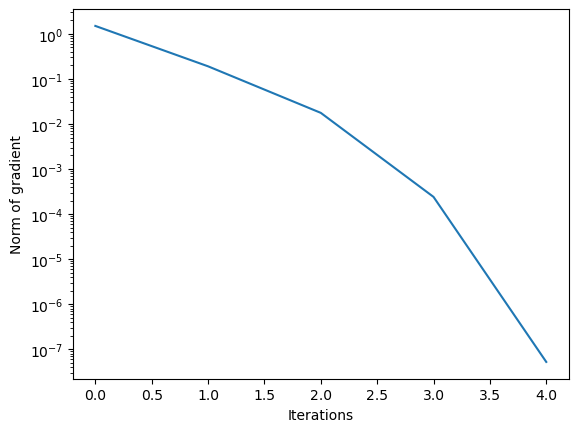

In [37]:
import matplotlib.pyplot as plt
plt.plot(grad_list)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Norm of gradient')

# Question 3.4:

In [38]:
w = np.ones(p)
grad_list_2 = []

In [39]:
while(True):
    hessian = hessian_f(w, X, y, rho)
    grad = grad_f(w, X, y, rho)
    norm_grad = np.linalg.norm(grad)
    if(norm_grad<10**-10):
        break
    grad_list.append(norm_grad)
    w = w - np.linalg.inv(hessian)@grad


C:\Users\thang\AppData\Local\Temp\ipykernel_7940\2725696130.py:7: RuntimeWarning: overflow encountered in exp
  Z = np.exp(-y*(w@X.T))/(1 + np.exp(-y*(w@X.T)))**2
C:\Users\thang\AppData\Local\Temp\ipykernel_7940\2725696130.py:7: RuntimeWarning: invalid value encountered in divide
  Z = np.exp(-y*(w@X.T))/(1 + np.exp(-y*(w@X.T)))**2
C:\Users\thang\AppData\Local\Temp\ipykernel_7940\611663028.py:6: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-y*(w@X.T))
C:\Users\thang\AppData\Local\Temp\ipykernel_7940\611663028.py:7: RuntimeWarning: invalid value encountered in multiply
  grad = -np.mean(y*X.T*exp/(1 + exp), axis=1)


KeyboardInterrupt: 

The number of the computation is too large, leads to overflow.

# Question 3.5:

Armijo's line search: We search for the first non negative integer l that satisfies:

$f(x^+(ba^l)) \leq f(x_k) + \beta \langle \triangledown f(x_k), x^+(ba^l) - x_k\rangle $ 

Classical choices for parameters: $a = 1/2$ and $b = 2\gamma_{k-1}$
Armijo's line search is Taylor's line search with $\beta = 1/2$


In [52]:
b = 2
a = 1/2
beta = 1/2
grad_list = []
n, p = X.shape
w = np.ones(p)
while True:
    
    hessian = hessian_f(w, X, y, rho)
    grad = grad_f(w, X, y, rho)
    l = 0
    
    while True:
        gamma = b*a**l
        w_k1 = w - gamma*np.linalg.inv(hessian)@grad
        result = func_f(w_k1, X, y, rho) - func_f(w, X, y, rho) - beta*grad@(w_k1 - w)
        if(result <= 0):
            w = w_k1
            break
        else:
            l = l + 1
    b = 2*gamma
    norm_grad = np.linalg.norm(grad)
    grad_list.append(norm_grad)
    if(norm_grad < 10**-10):
        break

0


C:\Users\thang\AppData\Local\Temp\ipykernel_7940\2151163815.py:4: RuntimeWarning: overflow encountered in exp
  f = np.mean(np.log(1 + np.exp(-y*(w@X.T)))) + rho/2 * np.inner(w[1:], w[1:])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


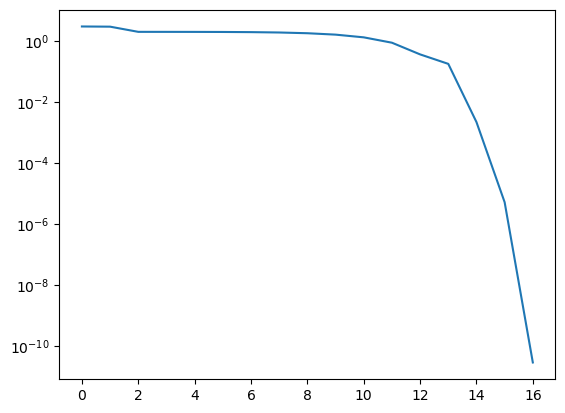

In [53]:
plt.plot(grad_list)
plt.yscale('log')

# Question 4.1:

Why can't we use Newton's method to solve this problem?

We can't use Newton's method because norm-1 is not differentible.

# Question 4.2:

$F_2 = f_2 + g_2$

$f_2 = \sum_{i=1}^n log(1+exp(-y_i(x_iw + w_0)))$

$g_2 = \rho \|w\|_1$

We write $x_iw + w_o$ as $X_iW$ with $W = [w_0, w]$ and $X_i = [1, x_i]$

$\frac{\partial f_2}{\partial W} = \sum_{i=1}^n \frac{-y_iX_iexp(-y_iX_iw)}{1+exp(-y_iX_iw)}$

$prox_{g_2}(v) = argmin_x (g_2 + \|x - v\|^2)$

The optimization problem: $x_{k+1} = prox_{g_2} (x_k - \gamma \triangledown f)$

# Question 4.3:

In [57]:
def prox_g2(v):
    return np.maximum(0, np.sign(v)*(np.absolute(v) - 1))

w = np.zeros(p)
rho = 0.02
grad_list = []

b = 2
a = 1/2
beta = 1/2
i = 0
while True:
    grad = grad_f(w, X, y, rho)
    norm_grad = np.linalg.norm(grad)
    grad_list.append(norm_grad)
    if i%100==0:
        print(i)
    i = i + 1
    if(norm_grad<10**-10):
        break
    l = 0
    while True:
        gamma = b*a**l
        w_k1 = prox_g2(w - gamma*grad)
        result = func_f(w_k1, X, y, rho) - func_f(w, X, y, rho) - beta * grad@(w_k1 - w)
        if(result<=0):
            w = w_k1
            break
        else:
            l = l + 1

    b = 2*gamma


0
100
200


KeyboardInterrupt: 